In [81]:
#libraries
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import os
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
from prophet import Prophet

pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)
sns.set(rc={"figure.figsize":(12,12)}) 
color_pal = sns.color_palette()

In [82]:
response = pd.read_csv("./data/response.csv")
response.rename(columns = {'Timestamp_UTC':'Timestamp'}, inplace = True) 
features = pd.read_csv("./data/features.csv")

df = pd.merge(features, response, on='Timestamp')
df = df.set_index("Timestamp")
df.index= pd.to_datetime(df.index)


In [83]:
df.head(10)

,Te,Ar,Ra,Wv,Pr,Hp,Heat
Timestamp,,,,,,,
2017-01-01 01:00:00,275.2,3.0,0.0,7.0,0.0,0.0,0.0
2017-01-01 02:00:00,275.4,9.0,0.0,8.0,0.0,0.0,0.0
2017-01-01 03:00:00,275.3,1.2,0.0,7.0,0.0,0.0,0.0
2017-01-01 04:00:00,275.1,9.5,0.0,8.0,0.0,0.0,0.0
2017-01-01 05:00:00,274.9,3.3,0.0,7.0,0.0,0.0,0.0
2017-01-01 06:00:00,274.3,7.3,0.0,8.0,0.0,0.0,0.0
2017-01-01 07:00:00,274.1,13.8,0.0,8.0,0.0,0.0,0.0
2017-01-01 08:00:00,273.8,0.4,0.0,7.0,0.0,0.0,0.0
2017-01-01 09:00:00,273.5,2.0,4.0,8.0,0.0,0.0,0.0


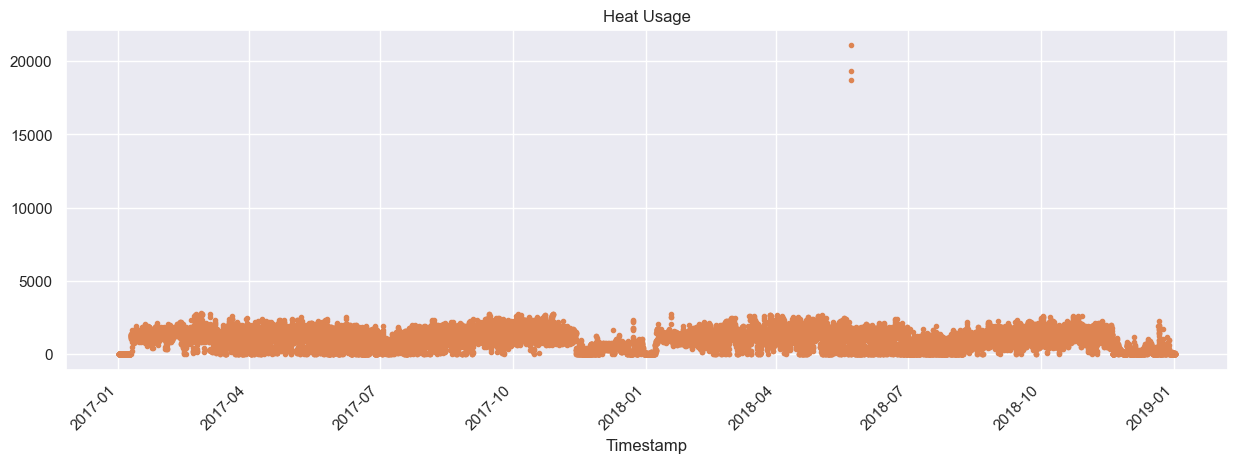

In [84]:
df["Heat"].plot(style=".", figsize=(15,5), color= color_pal[1], title="Heat Usage")
plt.xticks(rotation = 45);

In [44]:
df.corr()

,Te,Ar,Ra,Wv,Pr,Hp,Heat
Te,1.000000,-0.009215,0.492845,-0.119207,-0.035625,-0.101045,-0.209078
Ar,-0.009215,1.000000,-0.006858,-0.004811,-0.007206,0.003560,0.007952
Ra,0.492845,-0.006858,1.000000,-0.054687,-0.091762,-0.286948,-0.396146
Wv,-0.119207,-0.004811,-0.054687,1.000000,0.096378,-0.072823,0.023549
Pr,-0.035625,-0.007206,-0.091762,0.096378,1.000000,-0.013078,0.054613
Hp,-0.101045,0.003560,-0.286948,-0.072823,-0.013078,1.000000,0.485834
Heat,-0.209078,0.007952,-0.396146,0.023549,0.054613,0.485834,1.000000


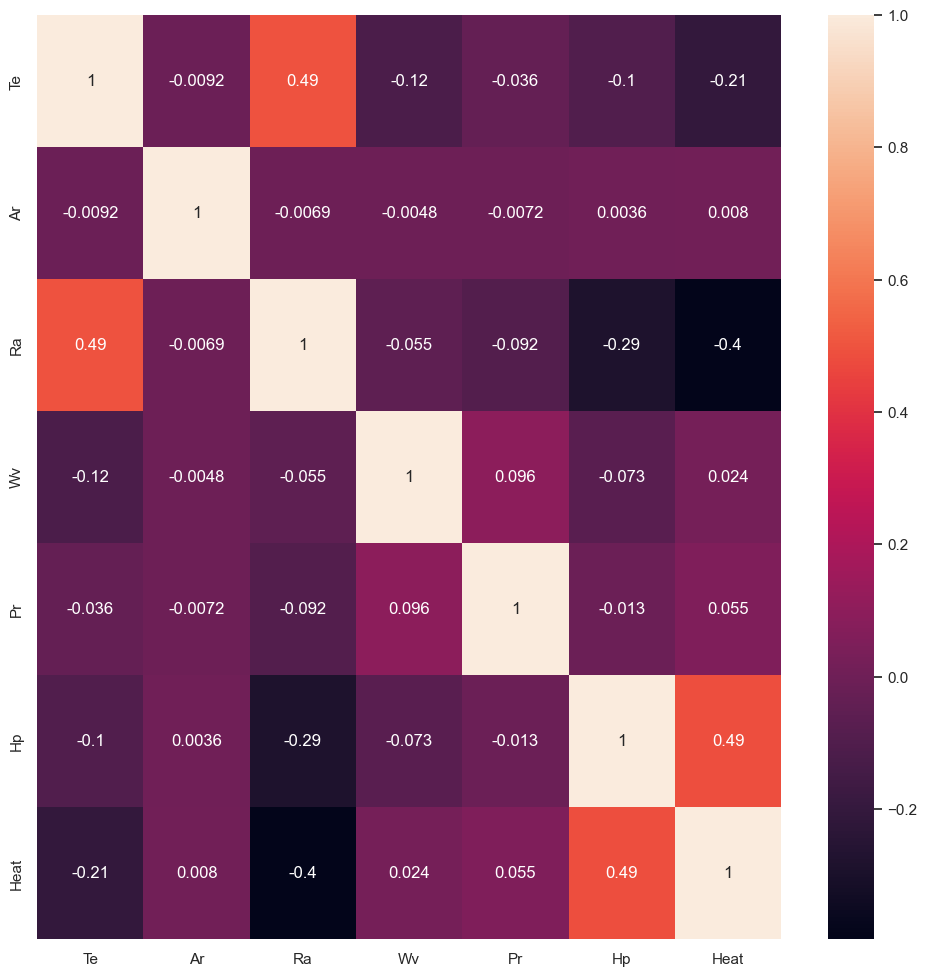

In [45]:
sns.heatmap(df.corr(), annot=True);

## Fill Missing Values

In [46]:
df.isnull().sum()

Te      2
Ar      0
Ra      0
Wv      0
Pr      0
Hp      0
Heat    2
dtype: int64

In [47]:
# https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/

def fill_nan_values(dataframe, feature):
    dataframe[feature]= dataframe[feature].interpolate(method='linear')

    return dataframe

df = fill_nan_values(df, "Heat")
df = fill_nan_values(df, "Te")


## Check and Remove Outliers

In [48]:
def check_outliers(dataframe, feature):
    print(f"Maximum {feature}:",df[feature].max())
    print(f"Average {feature}:",df[feature].mean())
    maximum_index = df[feature].idxmax()
    print(f"Index of maximum {feature} :",maximum_index,"\n")


for col in df.columns:
    check_outliers(df, col)

Maximum Te: 310.6
Average Te: 284.5860628170781
Index of maximum Te : 2018-07-27 14:00:00 

Maximum Ar: 14.4
Average Ar: 7.206133500541527
Index of maximum Ar : 2017-01-15 21:00:00 

Maximum Ra: 337.0
Average Ra: 47.11400558627373
Index of maximum Ra : 2018-05-22 12:00:00 

Maximum Wv: 150.0
Average Wv: 6.986627144730091
Index of maximum Wv : 2017-06-29 10:00:00 

Maximum Pr: 17.9
Average Pr: 0.09441372627258736
Index of maximum Pr : 2018-08-10 22:00:00 

Maximum Hp: 1335.2
Average Hp: 479.36120389899105
Index of maximum Hp : 2017-03-06 11:00:00 

Maximum Heat: 21080.0
Average Heat: 1011.5537546062518
Index of maximum Heat : 2018-05-22 14:00:00 



In [49]:
df['Heat'].describe()

count    17543.000000
mean      1011.553755
std        670.983679
min          0.000000
25%        508.053392
50%       1064.110318
75%       1467.869000
max      21080.000000
Name: Heat, dtype: float64

The maximum value is 21080.0, which is considerably higher than the upper quartile (Q3) of 1467.869, indicating the presence of potential outliers. The large difference between the maximum value and the upper quartile suggests that there may be outliers in the `Heat` variable.

In [50]:
df['Te'].describe()

count    17543.000000
mean       284.586063
std          6.399883
min        265.000000
25%        279.800000
50%        284.500000
75%        289.500000
max        310.600000
Name: Te, dtype: float64

The maximum value is 310.6, which is within a reasonable range compared to the upper quartile (Q3) of 289.5. There doesn't seem to be a clear indication of outliers in the variable `Te`. 

In [51]:
df['Ar'].describe()

count    17543.000000
mean         7.206134
std          4.163581
min          0.000000
25%          3.600000
50%          7.200000
75%         10.800000
max         14.400000
Name: Ar, dtype: float64

There doesn't seem to be any obvious indication of outliers for the feature `Ar`. The range between the minimum and maximum values is within a reasonable range, and the interquartile range (IQR) is from 3.6 to 10.8.

In [52]:
df['Hp'].describe()

count    17543.000000
mean       479.361204
std        298.422226
min          0.000000
25%        239.950000
50%        506.500000
75%        698.850000
max       1335.200000
Name: Hp, dtype: float64

In [53]:
target_index = pd.Timestamp('2017-03-06 11:00:00')
df_hp = df[(df.index >= '2017-03-06 08:00:00') & (df.index <= '2017-03-06 23:00:00')]
df_hp.style.apply(lambda x: ['background: darkblue' 
                             if (x.name == target_index)
                             else '' for i in x], axis=1)

,Te,Ar,Ra,Wv,Pr,Hp,Heat
Timestamp,,,,,,,
2017-03-06 08:00:00,279.000000,11.600000,13.000000,4.000000,0.000000,630.200000,1121.652436
2017-03-06 09:00:00,279.800000,14.400000,44.000000,3.000000,0.000000,1007.900000,300.452147
2017-03-06 10:00:00,280.200000,12.400000,66.000000,3.000000,0.000000,1149.400000,360.779648
2017-03-06 11:00:00,281.000000,1.300000,141.000000,2.000000,0.000000,1335.200000,111.914003
2017-03-06 12:00:00,281.000000,11.600000,173.000000,4.000000,0.000000,1312.300000,153.573495
2017-03-06 13:00:00,280.500000,12.100000,83.000000,5.000000,0.000000,1305.300000,1982.004589
2017-03-06 14:00:00,280.300000,0.800000,58.000000,6.000000,0.000000,1266.000000,1900.443836
2017-03-06 15:00:00,280.400000,12.200000,58.000000,6.000000,0.000000,1122.600000,1620.831781
2017-03-06 16:00:00,280.500000,7.300000,65.000000,8.000000,0.000000,997.400000,1057.279709


There is a significant change in several attributes in the greenhouse data at `2017-03-06 13:00:00`. Here are some observations:<br>

- The Solar Radiation (Ra) drops from 173.0 to 83.0.<br>
- The Wind Velocity (Wv) increases from 4.0 to 5.0.<br>
- The Heat Production (Heat) experiences a substantial spike from 1312.3 to 1982.0.<br>

These changes suggest a sudden fluctuation in environmental conditions in the greenhouse at that specific timestamp. The decrease in solar radiation could indicate a change in external light conditions, and the variations in wind velocity and heat production could be influenced by external factors affecting the greenhouse environment.

In [54]:
df['Wv'].describe()

count    17543.000000
mean         6.986627
std          3.495164
min          0.000000
25%          5.000000
50%          7.000000
75%          9.000000
max        150.000000
Name: Wv, dtype: float64

The Wv attribute exhibited a peak value of 150.0 at the timestamp `2017-06-29 10:00:00`. Recognizing this as an outlier, and considering the substantial difference compared to the 75th percentile, the outlier value will be adjusted to the average of the values from the preceding and succeeding hours.

In [55]:
df['Pr'].describe()

count    17543.000000
mean         0.094414
std          0.509607
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.900000
Name: Pr, dtype: float64

The data distribution of `Pr` is heavily skewed towards lower values, but the existence of a high maximum value indicates the possibility of an outlier. 

In [56]:
df['Ra'].describe()

count    17543.000000
mean        47.114006
std         76.444557
min          0.000000
25%          0.000000
50%          2.000000
75%         66.000000
max        337.000000
Name: Ra, dtype: float64

If the <b>Ra</b> (`Solar Radiation`) values are consistently greater than 300 in a greenhouse environment, it generally implies that the plants are receiving a significant amount of sunlight.<br>

High solar radiation levels contribute to an increase in temperature within the greenhouse. This can be beneficial in cooler climates or during colder seasons, helping to maintain optimal temperatures for plant growth. However from the values <b>2018-07-14</b> and <b>2017-05-09</b> for time 14:00:00, this not aligns as Heat changes drastically with the similar amount of Ra (308.0 in 2017 with 183.3 in Heat, 308.0 in 2018 with 0 in Heat).<br>

Depending on the greenhouse design, high solar radiation may contribute significantly to the overall energy balance. This could affect decisions related to heating and cooling systems within the greenhouse.

In [57]:
target_index = pd.Timestamp('2018-05-22 12:00:00')
df_hp = df[(df.index >= '2018-05-22 05:00:00') & (df.index <= '2018-05-22 20:00:00')]
df_hp.style.apply(lambda x: ['background: darkgreen' 
                             if (x.name == target_index)
                             else '' for i in x], axis=1)

,Te,Ar,Ra,Wv,Pr,Hp,Heat
Timestamp,,,,,,,
2018-05-22 05:00:00,287.100000,5.200000,0.000000,6.000000,0.400000,979.300000,1568.320909
2018-05-22 06:00:00,287.500000,0.500000,5.000000,5.000000,0.000000,1064.700000,1631.166978
2018-05-22 07:00:00,287.900000,8.300000,13.000000,2.000000,0.000000,828.000000,1166.835933
2018-05-22 08:00:00,289.100000,10.800000,31.000000,2.000000,0.000000,678.400000,650.955879
2018-05-22 09:00:00,292.200000,12.100000,101.000000,4.000000,0.000000,478.900000,273.993607
2018-05-22 10:00:00,294.100000,14.200000,158.000000,2.000000,0.000000,261.800000,0.000000
2018-05-22 11:00:00,295.700000,0.700000,259.000000,3.000000,0.000000,165.700000,0.000000
2018-05-22 12:00:00,292.200000,1.400000,337.000000,4.000000,0.000000,0.000000,0.000000
2018-05-22 13:00:00,291.800000,7.400000,287.000000,6.000000,0.000000,0.000000,0.000000


The observation of a maximum value at `337.0`, significantly surpassing the upper quartile (Q3) value of 66.0, raises concerns about a potential outlier in the variable `Ra`. Subsequently, I investigated instances where `Ra` exceeded 300, identifying 145 such occurrences. The consistent elevation in `Ra` values prompts further investigation into the underlying cause behind this unusual pattern.

In [58]:
def remove_outlier_day(dataframe,time_stamp,feature):
    # identifying the timestamp to replace
    timestamp_to_replace = pd.to_datetime(time_stamp)

    # extracting the heats from the previous and next days
    previous_day_heat = dataframe[dataframe.index == (timestamp_to_replace - pd.DateOffset(days=1))][feature].iloc[0]
    next_day_heat = dataframe[dataframe.index == (timestamp_to_replace + pd.DateOffset(days=1))][feature].iloc[0]

    # replacing the heat value
    dataframe.loc[dataframe.index == timestamp_to_replace, feature] = (previous_day_heat + next_day_heat) / 2

    return dataframe

In [59]:
def remove_outlier_hour(dataframe, time_stamp, feature):
    # the timestamp to replace
    timestamp_to_replace = pd.to_datetime(time_stamp)

    # extracting the heats from one hour before and after
    previous_hour_heat = dataframe[dataframe.index == (timestamp_to_replace - pd.DateOffset(hours=1))][feature].iloc[0]
    next_hour_heat = dataframe[dataframe.index == (timestamp_to_replace + pd.DateOffset(hours=1))][feature].iloc[0]

    # replacing the heat value
    dataframe.loc[dataframe.index == timestamp_to_replace, feature] = (previous_hour_heat + next_hour_heat) / 2

    return dataframe

In [60]:
df = remove_outlier_day(df,"2018-05-22 14:00:00","Heat")
df = remove_outlier_day(df,"2018-05-22 15:00:00","Heat")
df = remove_outlier_day(df,"2018-05-22 16:00:00","Heat")
# df[(df.index >= '2018-05-22 01:00:00') & (df.index <= '2018-05-22 23:00:00')]  # check the pattern for heat

df = remove_outlier_hour(df,"2018-08-10 22:00:00","Pr")
df = remove_outlier_hour(df, "2017-06-29 10:00:00", "Wv")
# df[(df.index >= '2017-06-29 01:00:00') & (df.index <= '2017-06-29 23:00:00')] # check the pattern for wv
# df[(df.index >= '2017-03-06 01:00:00') & (df.index <= '2017-03-06 23:00:00')] # check the pattern for hp

## Feature Engineering

Lag features represent past values of the target variable. They can help capture trends and seasonality.

In [61]:
# https://www.kaggle.com/code/ryanholbrook/time-series-as-features
# each value in 'Heat_Lag1' or 'Heat_Lag2' corresponds to the value of 'Heat' in the previous time step
df['Heat_Lag1'] = df['Heat'].shift(1)
df['Heat_Lag2'] = df['Heat'].shift(2)
# fill the NaN values
df['Heat_Lag1'] = df['Heat_Lag1'].fillna(0)
df['Heat_Lag2'] = df['Heat_Lag2'].fillna(0)


Computing rolling mean and rolling standard deviation to capture trends and smooth out noise.

In [62]:
df['Heat_RollingMean'] = df['Heat'].rolling(window=3).mean()
df['Heat_RollingStd'] = df['Heat'].rolling(window=3).std()
# fill the NaN values
df['Heat_RollingMean'] = df['Heat_RollingMean'].fillna(0)
df['Heat_RollingStd'] = df['Heat_RollingStd'].fillna(0)

Including weather-related features like temperature, humidity, and radiation. <br>

The optimum humidity for natural plant growth is in the range of 60-80% in most scenarios. In greenhouses, this range should be around 70-75%. How to adjust humidity in the greenhouse? As the greenhouse humidity decreases, the plant closes its stoma and stops water consumption.

In [63]:
df['Temperature_Humidity'] = df['Te'] * df['Hp']

In [64]:
df['temperature_diff'] = df['Te'] - df['Ar']
df['Te_Ra_interaction'] = df['Te'] * df['Ra']
df['wind_power'] = 0.5 * df['Pr'] * df['Wv']**2
df['humidity_ratio'] = df['Hp'] / (0.62198 + (1 - 0.62198) * df['Hp'])

In [65]:
# aggregating features (daily averages)
df['Daily_Avg_Humidity'] = df.groupby(pd.Grouper(freq='D'))['Hp'].transform('mean')
df['Daily_Avg_Photosynthesis'] = df.groupby(pd.Grouper(freq='D'))['Pr'].transform('mean')

In [66]:
# derive wind-chill factor
df['Wind_Chill_Factor'] = df['Te'] - (0.4275 * df['Wv']**0.16)
# temperature deviation
df['Te_Deviation'] = df['Te'] - df['Te'].mean()
# composite index
df['Environmental_Stress_Index'] = (df['Te'] + df['Ra'] + df['Hp']) / 3

In [67]:
df.index = pd.to_datetime(df.index)
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['hour'] = df.index.hour

In [68]:
df.head(5)

,Te,Ar,Ra,Wv,Pr,Hp,Heat,Heat_Lag1,Heat_Lag2,Heat_RollingMean,Heat_RollingStd,Temperature_Humidity,temperature_diff,Te_Ra_interaction,wind_power,humidity_ratio,Daily_Avg_Humidity,Daily_Avg_Photosynthesis,Wind_Chill_Factor,Te_Deviation,Environmental_Stress_Index,day_of_week,month,hour
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00,275.2,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.2,0.0,0.0,0.0,0.0,0.052174,274.616351,-9.386063,91.733333,6,1,1
2017-01-01 02:00:00,275.4,9.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,266.4,0.0,0.0,0.0,0.0,0.052174,274.803747,-9.186063,91.800000,6,1,2
2017-01-01 03:00:00,275.3,1.2,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,274.1,0.0,0.0,0.0,0.0,0.052174,274.716351,-9.286063,91.766667,6,1,3
2017-01-01 04:00:00,275.1,9.5,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.6,0.0,0.0,0.0,0.0,0.052174,274.503747,-9.486063,91.700000,6,1,4
2017-01-01 05:00:00,274.9,3.3,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271.6,0.0,0.0,0.0,0.0,0.052174,274.316351,-9.686063,91.633333,6,1,5


## Distribution Visualization


<b>kdeplot</b> displays the distribution of a continuous variable. They are similar to histograms, but instead of representing the data as bars, density plots use a smooth curve to estimate the density of the data.<br>

<b>lineplots</b> are used to visualize trends in data over time or other continuous variables. In a line plot, each data point is connected by a line, creating a smooth curve.

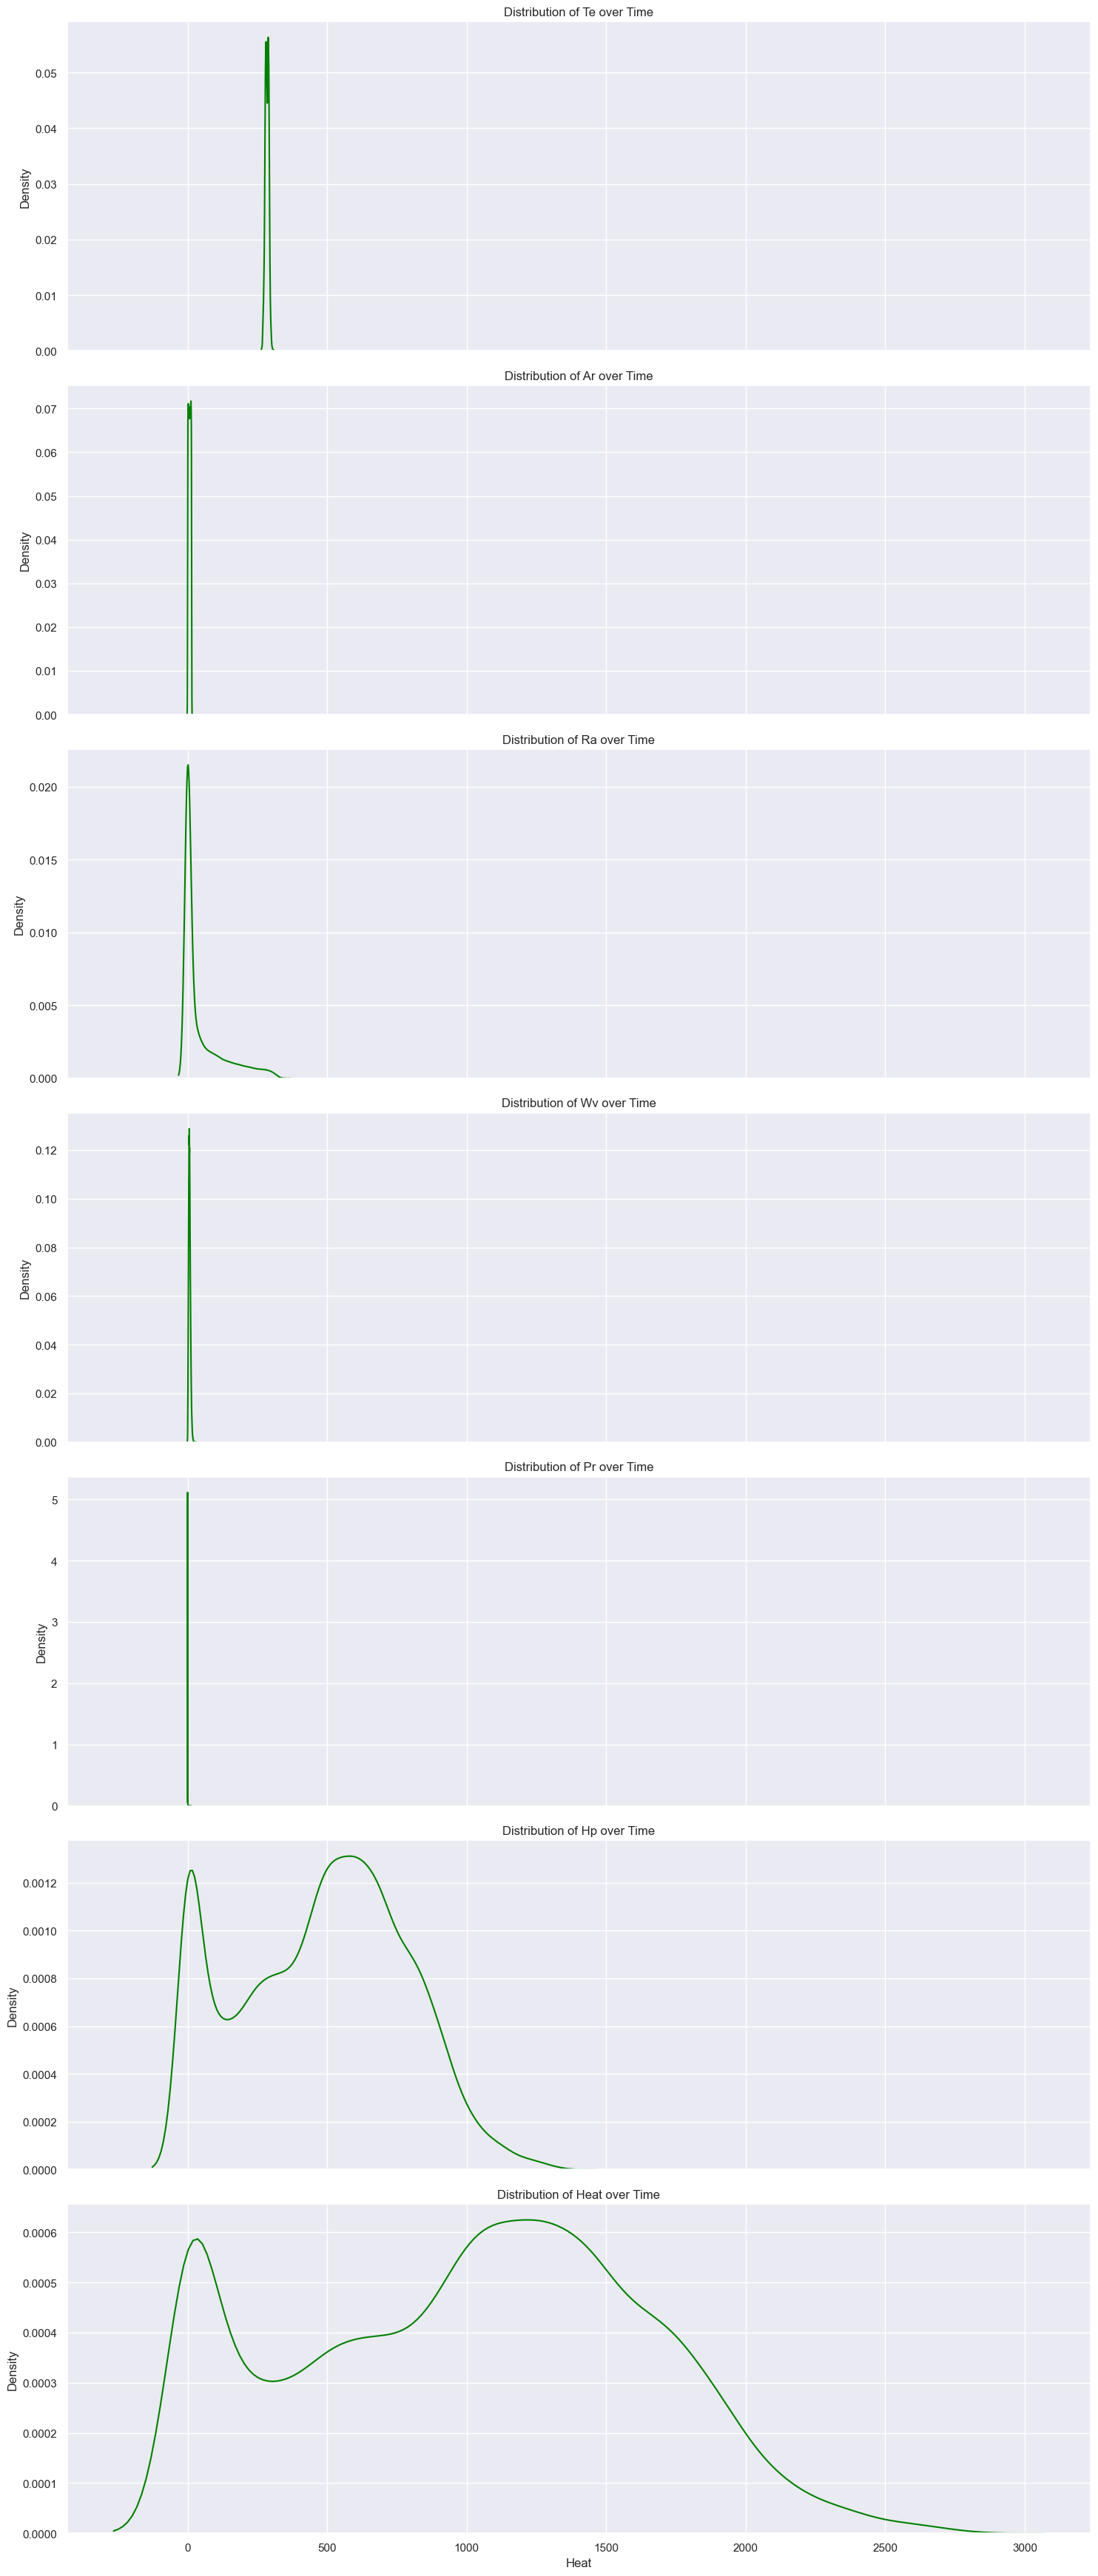

In [69]:
def kdeplot(dataframe, selected_columns):
    # resetting to avoid duplicates
    dataframe_reset = dataframe.reset_index()
    
    # each feature in a separate subplot
    fig, axes = plt.subplots(len(selected_columns), 1, figsize=(15, 5 * len(selected_columns)), sharex=True)

    for i, feature in enumerate(selected_columns):
        # the current feature in the i-th subplot
        sns.kdeplot(data=dataframe_reset, x=feature, ax=axes[i], color='green')

        axes[i].set_title(f'Distribution of {feature} over Time')
        axes[i].set_xlabel(f'{feature}')
        axes[i].set_ylabel('Density')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# usage
selected_columns = ["Te", "Ar", "Ra", "Wv", "Pr", "Hp", "Heat"]
kdeplot(df, selected_columns)

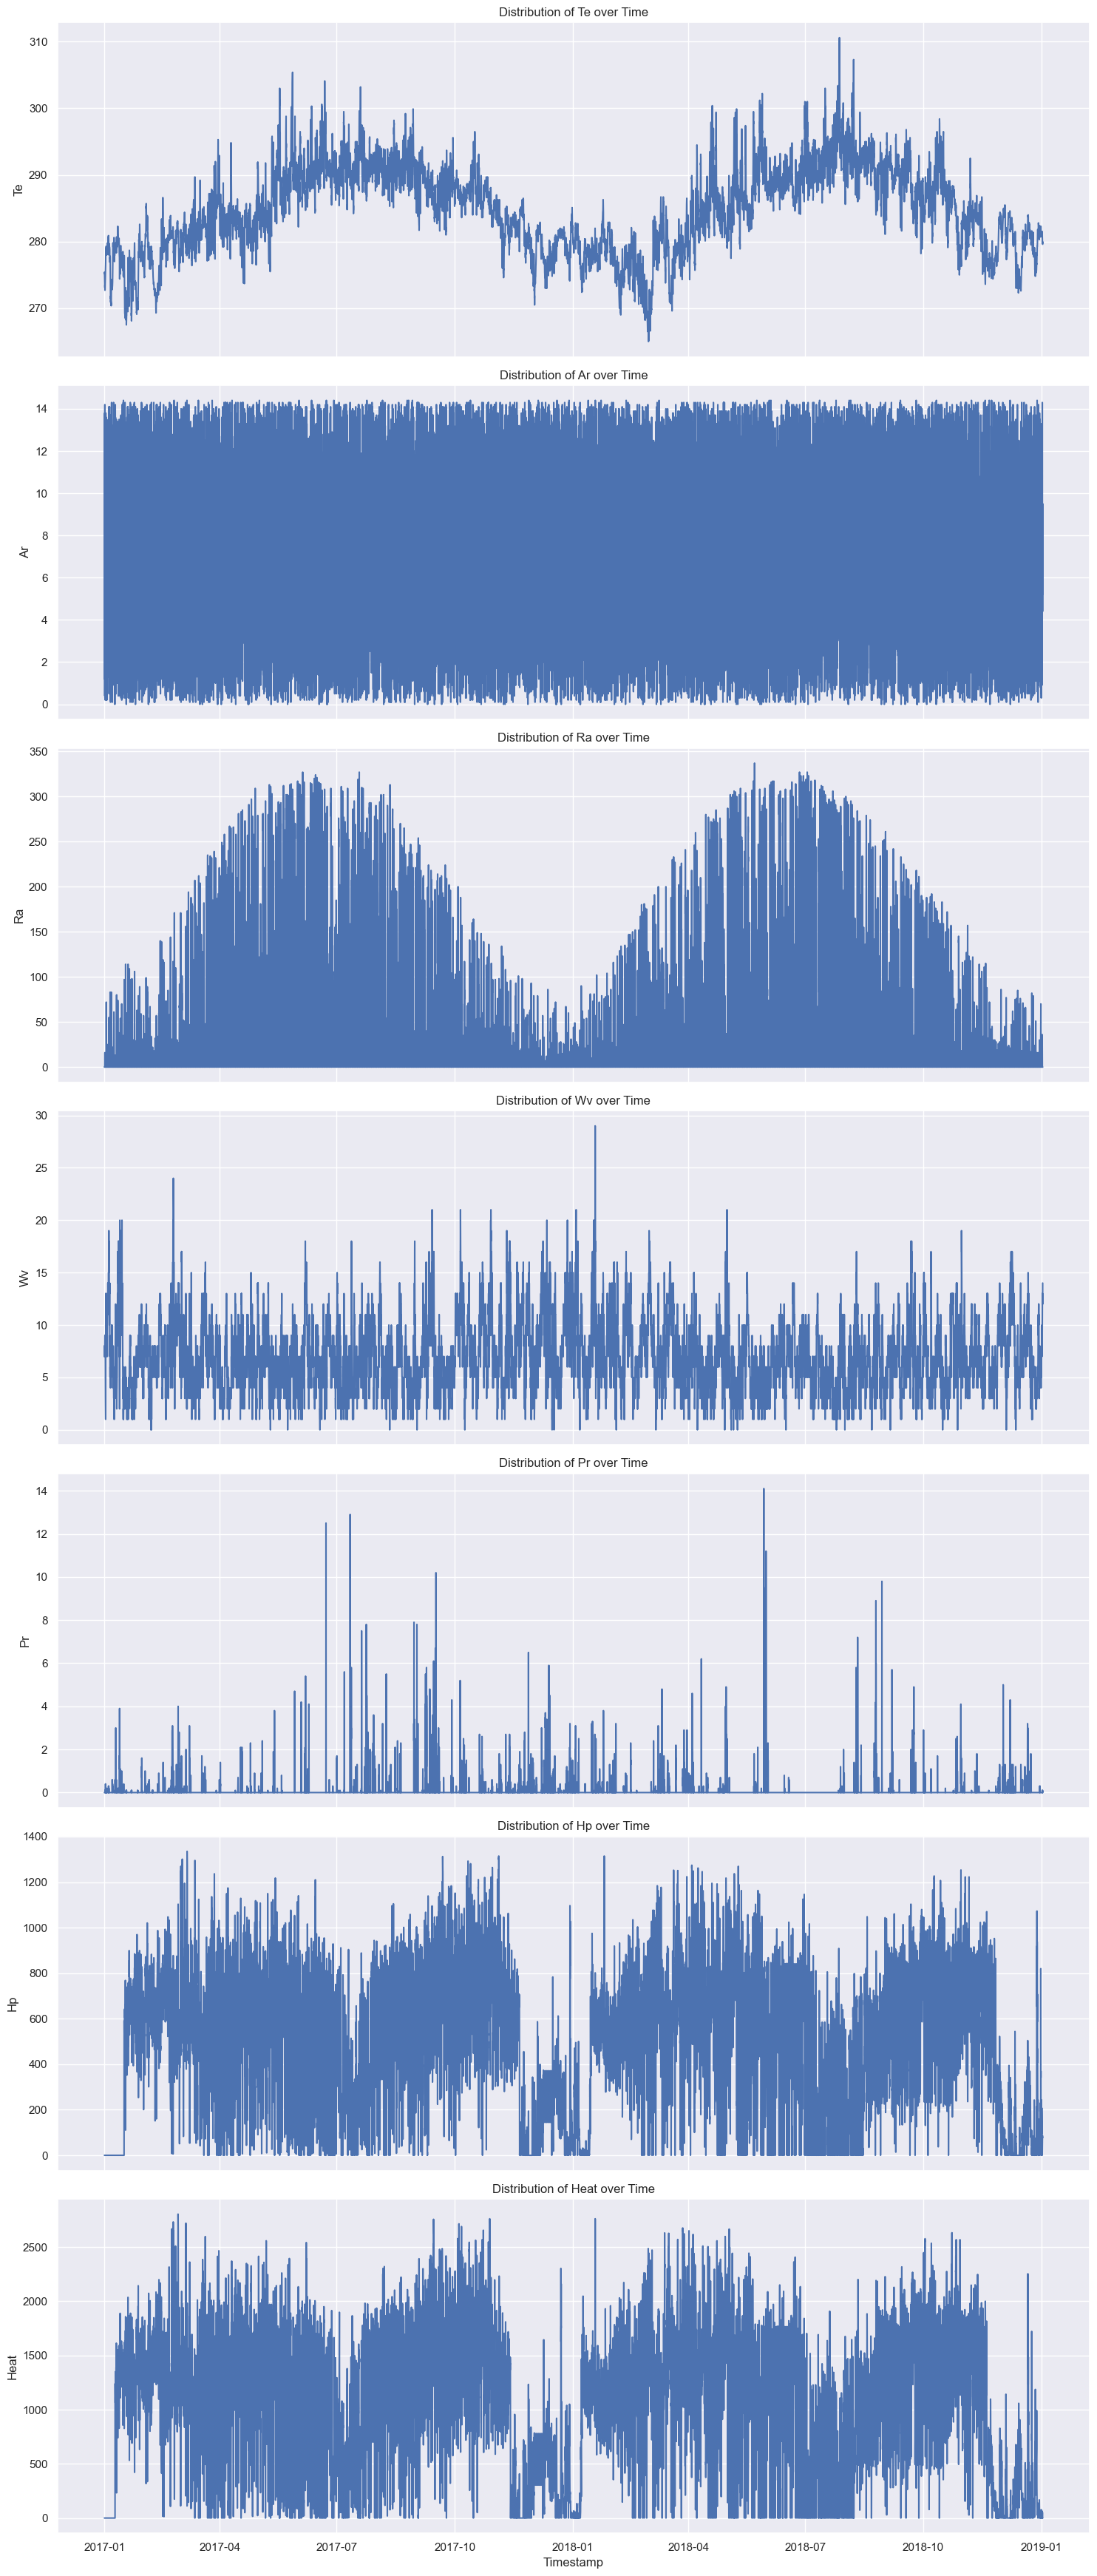

In [70]:
def lineplot(dataframe, selected_columns):
    # resetting to avoid duplicates
    dataframe_reset = dataframe.reset_index()
    
    # each feature in a separate subplot
    fig, axes = plt.subplots(len(selected_columns), 1, figsize=(15, 5 * len(selected_columns)), sharex=True)

    for i, feature in enumerate(selected_columns):
        # the current feature in the i-th subplot
        #sns.kdeplot(data=dataframe_reset, x=feature, ax=axes[i], color='green')
        sns.lineplot(data=dataframe_reset, x='Timestamp', y=feature, ax=axes[i])

        axes[i].set_title(f'Distribution of {feature} over Time')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(f'{feature}')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# usage
selected_columns = ["Te", "Ar", "Ra", "Wv", "Pr", "Hp", "Heat"]
lineplot(df, selected_columns)

## Normalize the Data

In [71]:
# normalization
# scaler = MinMaxScaler()
# df_normalized = df.copy()
# columns_to_normalize = df.columns
# df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

## Random Forest Regression Model

In [72]:
# https://www.mlq.ai/time-series-with-tensorflow-evaluation-metrics/

df.index = pd.to_datetime(df.index)

# the date for splitting the data
split_date = '2018-06-01'
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

X_train, y_train = train_data.drop('Heat', axis=1), train_data['Heat']
X_test, y_test = test_data.drop('Heat', axis=1), test_data['Heat']

# initializing and train a random forest regressor on the training set
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# making predictions on the testing set
y_pred = model.predict(X_test)

# evaluating the model on the testing set
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# the date for predictions
selected_day = '2018-08-20'

# filtering the original dataset for the selected day
selected_day_data = df[df.index.date == pd.to_datetime(selected_day).date()]
selected_day_predictions = model.predict(selected_day_data.drop('Heat', axis=1))

# the dataframe with actual and predicted values
results_df = pd.DataFrame({'Timestamp': selected_day_data.index, 'Actual': selected_day_data['Heat'], 'Predicted': selected_day_predictions})
results_df = results_df.set_index('Timestamp')
print(f'\nActual and Predicted Results for {selected_day}:')
print(results_df)


Mean Squared Error on Test Set: 1526.6421473400494

Actual and Predicted Results for 2018-08-20:
                          Actual    Predicted
Timestamp                                    
2018-08-20 00:00:00   384.221030   364.830845
2018-08-20 01:00:00   386.076264   364.437165
2018-08-20 02:00:00  1123.788951   962.058395
2018-08-20 03:00:00  1256.575731  1297.768555
2018-08-20 04:00:00  1267.317238  1279.690411
2018-08-20 05:00:00  1316.757977  1315.584479
2018-08-20 06:00:00  1330.476846  1311.566978
2018-08-20 07:00:00  1290.558343  1303.297134
2018-08-20 08:00:00  1233.771040  1241.924729
2018-08-20 09:00:00   824.498550   885.092250
2018-08-20 10:00:00   494.276898   474.822820
2018-08-20 11:00:00   490.657212   477.701213
2018-08-20 12:00:00   503.670340   496.706299
2018-08-20 13:00:00   495.145592   504.965498
2018-08-20 14:00:00   495.382392   512.038668
2018-08-20 15:00:00   569.056144   573.867859
2018-08-20 16:00:00   592.121341   571.564551
2018-08-20 17:00:00   545.332

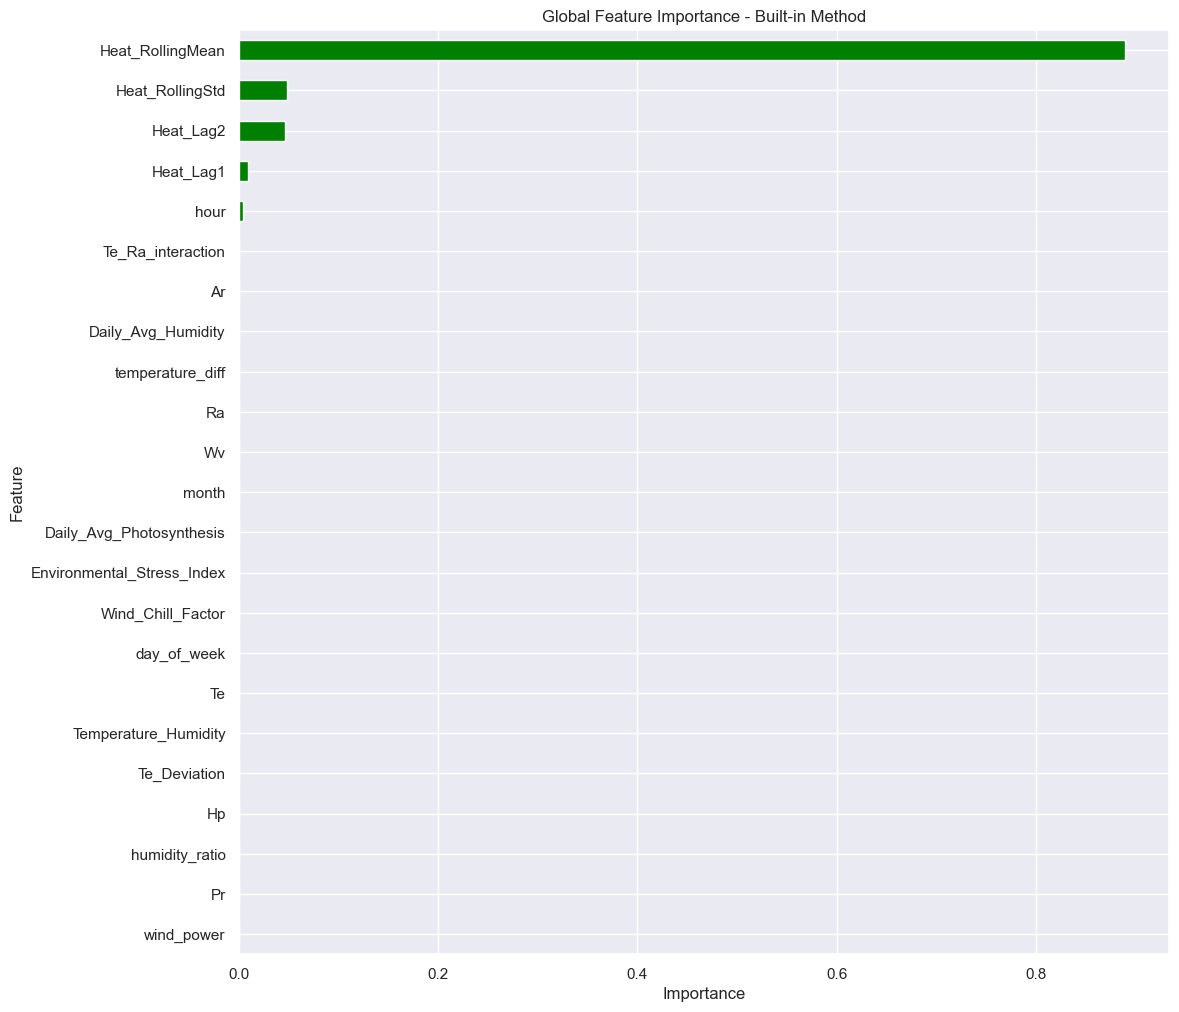

In [73]:
# https://forecastegy.com/posts/feature-importance-in-random-forests/

global_importances = pd.Series(model.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method");

## Fine Tuning RFR Model

In [74]:
# https://medium.com/@bhatshrinath41/a-comprehensive-guide-to-random-forest-regression-43da559342bf

df.index = pd.to_datetime(df.index)

# the date for splitting the data
split_date = '2018-06-01'
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

X_train, y_train = train_data.drop('Heat', axis=1), train_data['Heat']
X_test, y_test = test_data.drop('Heat', axis=1), test_data['Heat']

param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print(best_params)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30}


In [75]:
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)

# making predictions on the testing set
y_pred = rf.predict(X_test)

# evaluating the model on the testing set
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# the date for predictions
selected_day = '2018-08-20'

# filtering the original dataset for the selected day
selected_day_data = df[df.index.date == pd.to_datetime(selected_day).date()]
selected_day_predictions = rf.predict(selected_day_data.drop('Heat', axis=1))

# the dataframe with actual and predicted values
results_df = pd.DataFrame({'Timestamp': selected_day_data.index, 'Actual': selected_day_data['Heat'], 'Predicted': selected_day_predictions})
results_df = results_df.set_index('Timestamp')
print(f'\nActual and Predicted Results for {selected_day}:')
print(results_df)

Mean Squared Error on Test Set: 1475.6619667669318

Actual and Predicted Results for 2018-08-20:
                          Actual    Predicted
Timestamp                                    
2018-08-20 00:00:00   384.221030   364.694192
2018-08-20 01:00:00   386.076264   366.207602
2018-08-20 02:00:00  1123.788951   997.612121
2018-08-20 03:00:00  1256.575731  1294.633746
2018-08-20 04:00:00  1267.317238  1279.064716
2018-08-20 05:00:00  1316.757977  1311.474069
2018-08-20 06:00:00  1330.476846  1312.143066
2018-08-20 07:00:00  1290.558343  1300.187285
2018-08-20 08:00:00  1233.771040  1245.121043
2018-08-20 09:00:00   824.498550   885.469443
2018-08-20 10:00:00   494.276898   480.895191
2018-08-20 11:00:00   490.657212   488.326235
2018-08-20 12:00:00   503.670340   498.111376
2018-08-20 13:00:00   495.145592   502.319786
2018-08-20 14:00:00   495.382392   511.095417
2018-08-20 15:00:00   569.056144   574.360241
2018-08-20 16:00:00   592.121341   572.117975
2018-08-20 17:00:00   545.332

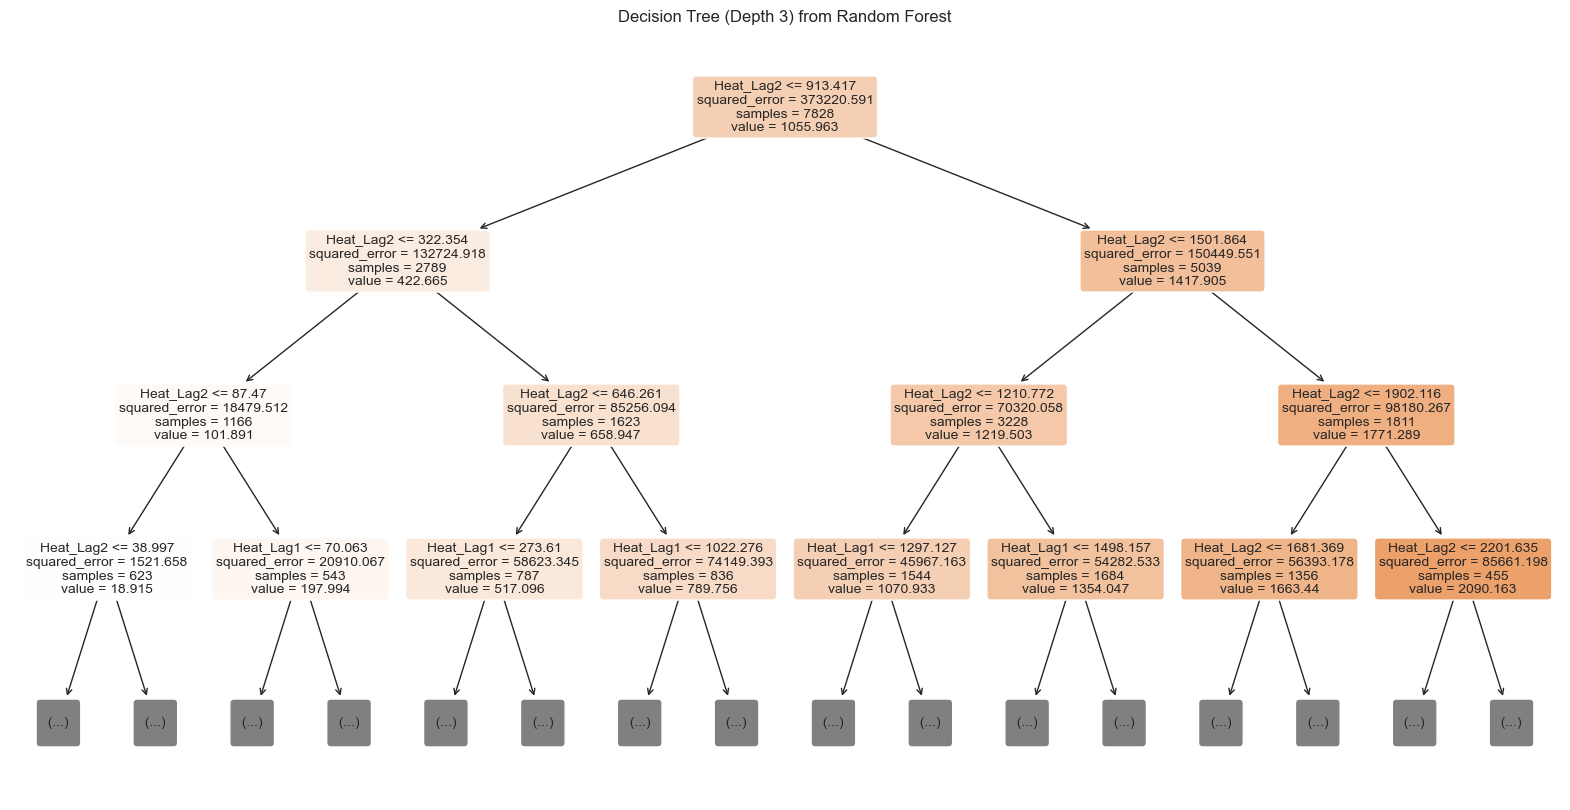

In [76]:
tree_to_plot = rf.estimators_[0]

# Limit the depth of the tree to be plotted (adjust as needed)
max_depth_to_plot = 3

# Plot the decision tree with limited depth
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=max_depth_to_plot)
plt.title(f"Decision Tree (Depth {max_depth_to_plot}) from Random Forest")
plt.show()

## Prophet Model

In [77]:
# https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

df.index = pd.to_datetime(df.index)

# columns to normalize
columns_to_normalize = df.columns 

# normalization
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print("\n")
print(df_normalized.head(10))
print("\n")

# the date range for evaluation (2018-07-01 and 2018-07-02)
evaluation_start_date = '2018-07-01'
evaluation_end_date = '2018-07-02'

# training set
pjme_train = df_normalized.loc[df_normalized.index < evaluation_start_date].copy()
pjme_train = pjme_train.reset_index()  # reset index to use Timestamp as ds
pjme_train = pjme_train.rename(columns={'Timestamp': 'ds', 'Heat': 'y'})

# test set
pjme_test = df_normalized.loc[(df_normalized.index >= evaluation_start_date) & (df_normalized.index <= evaluation_end_date)].copy()
pjme_test = pjme_test.reset_index()  # reset index to use Timestamp as ds
pjme_test = pjme_test.rename(columns={'Timestamp': 'ds', 'Heat': 'y'})

# initially I choose `daily_seasonality=False`, but `True` effected the model prediction positively.
model = Prophet(daily_seasonality=True)
model.fit(pjme_train)

# predicting on the test set with hourly frequency
pjme_test_fcst = model.predict(df=pjme_test)

# extracting hour-based predictions and actual values
hourly_predictions = pjme_test_fcst[['ds', 'yhat']].set_index('ds')
hourly_actuals = pjme_test.set_index('ds')['y']

# predicted and actual values in a df
evaluation_results = pd.DataFrame({'Actual': hourly_actuals, 'Predicted': hourly_predictions['yhat']})
evaluation_results.index.name = 'Timestamp' # rename ds as Timestamp
print("\n",evaluation_results)




                           Te        Ar        Ra        Wv   Pr   Hp  Heat  Heat_Lag1  Heat_Lag2  Heat_RollingMean  Heat_RollingStd  Temperature_Humidity  temperature_diff  Te_Ra_interaction  wind_power  humidity_ratio  Daily_Avg_Humidity  Daily_Avg_Photosynthesis  Wind_Chill_Factor  Te_Deviation  Environmental_Stress_Index  day_of_week  month      hour
Timestamp                                                                                                                                                                                                                                                                                                                                                           
2017-01-01 01:00:00  0.223684  0.208333  0.000000  0.241379  0.0  0.0   0.0        0.0        0.0               0.0              0.0                   0.0          0.357143           0.000000         0.0             0.0                 0.0                  0.031862           0.224602

14:10:42 - cmdstanpy - INFO - Chain [1] start processing
14:10:52 - cmdstanpy - INFO - Chain [1] done processing



                        Actual  Predicted
Timestamp                               
2018-07-01 00:00:00  0.311656   0.397752
2018-07-01 01:00:00  0.452935   0.414824
2018-07-01 02:00:00  0.526015   0.442400
2018-07-01 03:00:00  0.500455   0.478430
2018-07-01 04:00:00  0.425249   0.509426
2018-07-01 05:00:00  0.303395   0.517524
2018-07-01 06:00:00  0.249107   0.492215
2018-07-01 07:00:00  0.171431   0.436982
2018-07-01 08:00:00  0.101852   0.366044
2018-07-01 09:00:00  0.000000   0.295252
2018-07-01 10:00:00  0.000000   0.235506
2018-07-01 11:00:00  0.000000   0.192984
2018-07-01 12:00:00  0.000000   0.172822
2018-07-01 13:00:00  0.000000   0.179750
2018-07-01 14:00:00  0.000000   0.213548
2018-07-01 15:00:00  0.000000   0.264284
2018-07-01 16:00:00  0.000000   0.314106
2018-07-01 17:00:00  0.026516   0.346611
2018-07-01 18:00:00  0.103356   0.356894
2018-07-01 19:00:00  0.157454   0.353581
2018-07-01 20:00:00  0.080259   0.350813
2018-07-01 21:00:00  0.137715   0.357150
2018-07-01 22:

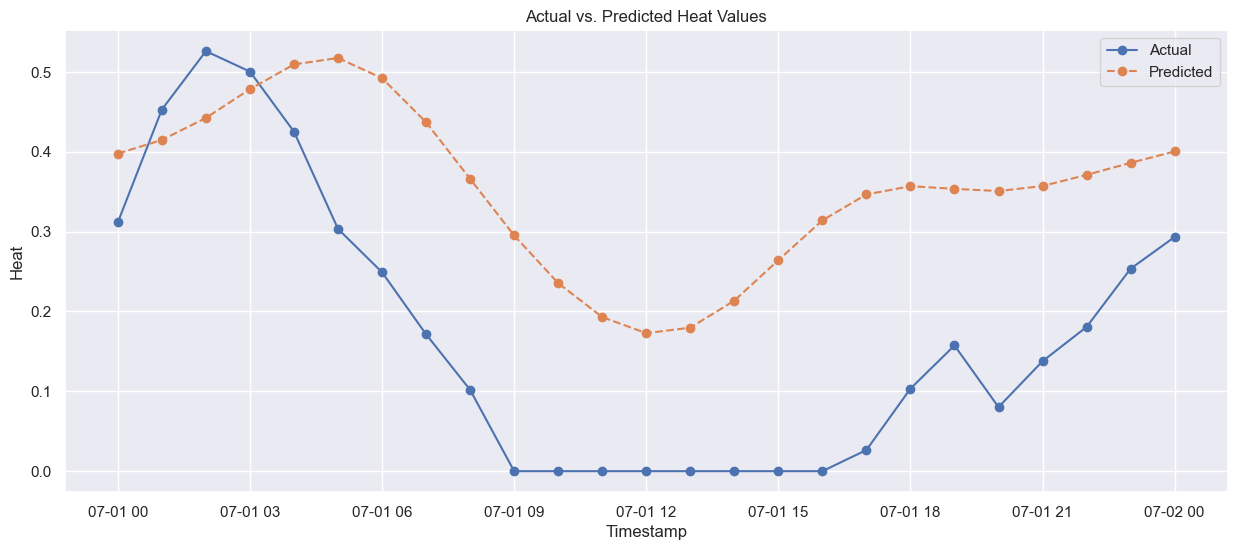

In [78]:
plt.figure(figsize=(15, 6))
# actual values
plt.plot(evaluation_results.index, evaluation_results['Actual'], label='Actual', marker='o')
# predicted values
plt.plot(evaluation_results.index, evaluation_results['Predicted'], label='Predicted', linestyle='--', marker='o')

plt.xlabel('Timestamp')
plt.ylabel('Heat')
plt.title('Actual vs. Predicted Heat Values')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# evaluation metrics
mse = mean_squared_error(evaluation_results['Actual'], evaluation_results['Predicted'])
mae = mean_absolute_error(evaluation_results['Actual'], evaluation_results['Predicted'])

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.04466926525595858
Mean Absolute Error (MAE): 0.19436424674762254
